### SE-ResNeXt50_32x4d
#### 前提条件
* トリミング画像をnew_data/からdata/crip_~に移し替えていること
* data/add_bridge/が存在し、アップサンプルした画像が存在していること
* regular6,8,47,61,95を削除
* potato0を削除
* horn53,44,32,30,16を削除

In [1]:
import os
import glob
import random
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import DataLoader
import albumentations as A
from sklearn.model_selection import StratifiedKFold
import pretrainedmodels

In [2]:
device = torch.device("cuda", 0) if torch.cuda.is_available() else "cpu"
count = torch.cuda.device_count()
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
SEED = 42
fix_seed(SEED)

In [3]:
BASE1 = "progress"
DAY = "/test"#好きな名前を入れる（自分は日付をいれます）
MODEL_PATH = "{}/model".format(BASE1 + DAY)
PIC_PATH = "{}/pic".format(BASE1 + DAY)
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(PIC_PATH, exist_ok=True)

In [4]:
df = pd.read_csv("csv/train_master.tsv")
label = np.array(df["flag"])

In [7]:
def inverse_lookup(d, x):
    file_name = d["file_name"]
    flag = d["flag"]
    for k, v in file_name.items():
        if x == v:
            return flag[k]
def make_datapath_list(root_path):
    path_list = []
    target_path = os.path.join("data" + root_path + f'/*.jpeg')
    for path in glob.glob(target_path):
        path_list.append(path)
    path_list.sort()
    path_list = [os.path.basename(p) for p in path_list]
    return path_list

In [8]:
bridge = make_datapath_list('/crip_train/bridge')
bridge_data = [Image.open('data/crip_train/bridge/' + i) for i in bridge]
bridge_label = np.array([inverse_lookup(df.to_dict(), os.path.basename(b)) for b in bridge])
horn = make_datapath_list('/crip_train/horn')
horn_data = [Image.open('data/crip_train/horn/' + i) for i in horn]
horn_label = np.array([inverse_lookup(df.to_dict(), os.path.basename(b)) for b in horn])
potato = make_datapath_list('/crip_train/potato')
potato_data = [Image.open('data/crip_train/potato/' + i) for i in potato]
potato_label = np.array([inverse_lookup(df.to_dict(), os.path.basename(b)) for b in potato])
regular = make_datapath_list('/crip_train/regular')
regular_data = [Image.open('data/crip_train/regular/' + i) for i in regular]
regular_label = np.array([inverse_lookup(df.to_dict(), os.path.basename(b)) for b in regular])

In [9]:
size=(224,224)
bridge_resize= np.array([np.array(img.resize(size, Image.LANCZOS), dtype="uint8") for img in bridge_data])
horn_resize= np.array([np.array(img.resize(size, Image.LANCZOS), dtype="uint8") for img in horn_data])
potato_resize= np.array([np.array(img.resize(size, Image.LANCZOS), dtype="uint8") for img in potato_data])
regular_resize= np.array([np.array(img.resize(size, Image.LANCZOS), dtype="uint8") for img in regular_data])

In [10]:
#ラベル毎に分かれているのでStratifiedKFoldである必要は無いです。
#試行錯誤中にこうなっているだけです。
split=5
bridge_sp = StratifiedKFold(n_splits=split, random_state=0, shuffle=True)
horn_sp = StratifiedKFold(n_splits=split, random_state=0, shuffle=True)
potato_sp = StratifiedKFold(n_splits=split, random_state=0, shuffle=True)
regular_sp = StratifiedKFold(n_splits=split, random_state=0, shuffle=True)

In [11]:
class GridMask():
    def __init__(self, p=0.6, d_range=(96, 224), r=0.6):
        self.p = p
        self.d_range = d_range
        self.r = r
        
    def __call__(self, sample):
        """
        sample: torch.Tensor(3, height, width)
        """
        if np.random.uniform() > self.p:
            return sample
        sample = sample.numpy()
        side = sample.shape[1]
        d = np.random.randint(*self.d_range, dtype=np.uint8)
        r = int(self.r * d)
        
        mask = np.ones((side+d, side+d), dtype=np.uint8)
        for i in range(0, side+d, d):
            for j in range(0, side+d, d):
                mask[i: i+(d-r), j: j+(d-r)] = 0
        delta_x, delta_y = np.random.randint(0, d, size=2)
        mask = mask[delta_x: delta_x+side, delta_y: delta_y+side]
        sample *= np.expand_dims(mask, 0)
        return torch.from_numpy(sample)

class MyDataset3(torch.utils.data.Dataset):
    def __init__(self, file_list, label_list = None, P = None, A = None):
        self.P = P
        self.A = A
        self.data = file_list
        self.label = label_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.label is not None:
            label = self.label[idx]
        else:
            label = 0
        data = Image.fromarray(data)
        if self.P:
            data = self.P(data)
        if self.A:
            data = np.asarray(data).transpose(1,2,0)
            image = self.A(image = data)
            data = image['image']
        data = data.transpose(2,1,0)
        return data.astype('f'), label

In [12]:
#GaussNoiseは実際要らなかったかも
train_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    GridMask(p=0.5, d_range=(96, 224), r=0.5),
])
val_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_A = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-5,5), p=0.3),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])
val_A = A.Compose([
])

In [15]:
class ResNet(nn.Module):
    def __init__(self, pretrained_res_model, class_num):
        super(ResNet, self).__init__()
        self.eff = pretrained_res_model
        self.fc1 = nn.Linear(1000, 100)
        self.fc2 = nn.Linear(100, class_num)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, input_ids):
        states = self.eff(input_ids)
        states = self.relu(self.fc1(states))
        states = self.dropout(states)
        states = self.fc2(states)
        return states
def save_plot(train,val,tlabel,vlabel,path):
    fig=plt.figure()
    plt.style.use("ggplot")
    plt.plot(train[5:],label=tlabel)
    plt.plot(val[5:],label=vlabel)
    plt.legend()
    fig.savefig(path)
    return

====================fold0====================


  0%|          | 0/1 [00:00<?, ?it/s]

epoch:0, loss:0.6268414258956909, f1:0.7727721545751193, val loss:0.6573373079299927, val f1:0.7912087912087912


100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


====================fold1====================


  0%|          | 0/1 [00:00<?, ?it/s]

epoch:0, loss:0.6236221075057984, f1:0.8087510072802047, val loss:0.6605991721153259, val f1:0.7912087912087912


100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


====================fold2====================


  0%|          | 0/1 [00:00<?, ?it/s]

epoch:0, loss:0.696367371082306, f1:0.5677041017423237, val loss:0.6578205823898315, val f1:0.7816091954022989


100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


====================fold3====================


  0%|          | 0/1 [00:00<?, ?it/s]

epoch:0, loss:0.6445330262184144, f1:0.7799150220455546, val loss:0.6524754166603088, val f1:0.7816091954022989


100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


====================fold4====================


  0%|          | 0/1 [00:00<?, ?it/s]

epoch:0, loss:0.6127024292945862, f1:0.8080794371848012, val loss:0.6995587348937988, val f1:0.7816091954022989


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


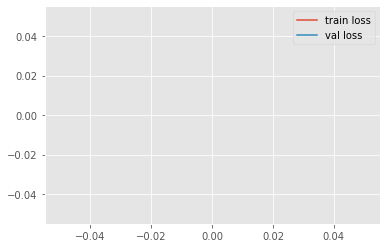

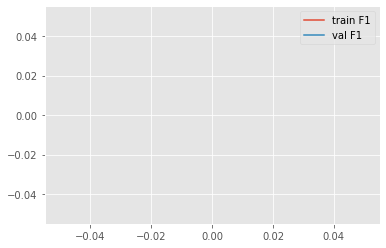

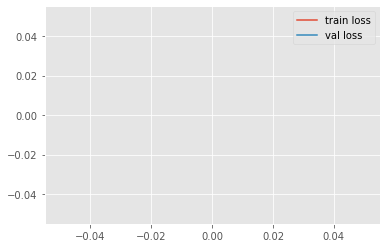

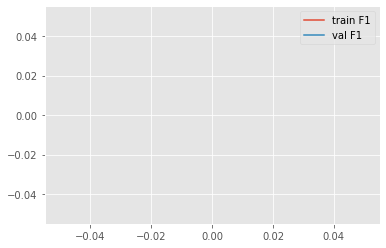

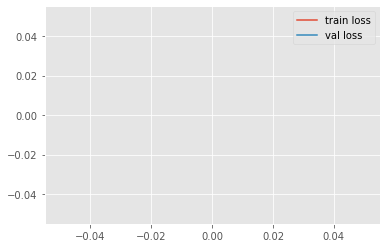

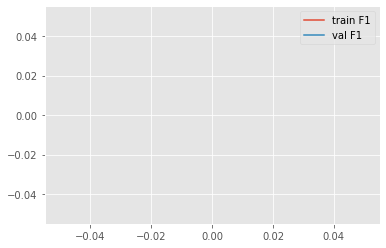

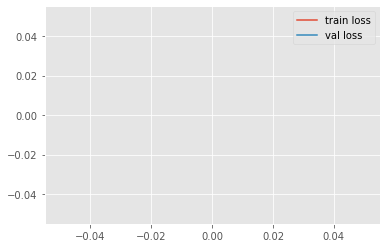

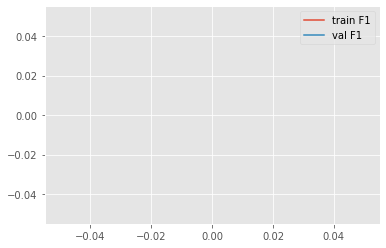

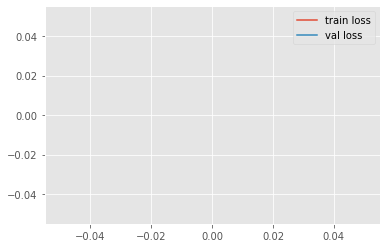

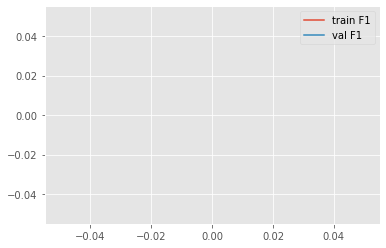

In [16]:
#300で試してました。
num_epoch = 1
for i in range(split):
    print(f"====================fold{i}====================")
    bridge_idx, bridge_idy = list(bridge_sp.split(bridge_resize, bridge_label))[i]
    horn_idx, horn_idy = list(horn_sp.split(horn_resize, horn_label))[i]
    potato_idx, potato_idy = list(potato_sp.split(potato_resize, potato_label))[i]
    regular_idx, regular_idy = list(regular_sp.split(regular_resize, regular_label))[i]
    train_bridge_list, val_bridge_list = bridge_resize[bridge_idx], bridge_resize[bridge_idy]
    train_bridge_label, val_bridge_label = bridge_label[bridge_idx], bridge_label[bridge_idy]
    train_horn_list, val_horn_list = horn_resize[horn_idx], horn_resize[horn_idy]
    train_horn_label, val_horn_label = horn_label[horn_idx], horn_label[horn_idy]
    train_potato_list, val_potato_list = potato_resize[potato_idx], potato_resize[potato_idy]
    train_potato_label, val_potato_label = potato_label[potato_idx], potato_label[potato_idy]
    train_regular_list, val_regular_list = regular_resize[regular_idx], regular_resize[regular_idy]
    train_regular_label, val_regular_label = regular_label[regular_idx], regular_label[regular_idy]
    train_list = np.concatenate([train_bridge_list, train_horn_list, train_potato_list, train_regular_list])
    val_list = np.concatenate([val_bridge_list, val_horn_list, val_potato_list, val_regular_list])
    train_label = np.concatenate([train_bridge_label, train_horn_label, train_potato_label, train_regular_label])
    val_label = np.concatenate([val_bridge_label, val_horn_label, val_potato_label, val_regular_label])
    
    s = ["s_"+d for d in np.array(bridge)[bridge_idx]]
    index1 = [i for i,add in enumerate(add_bridge) if add in np.array(bridge)[bridge_idx]]
    index2 = [i for i,add in enumerate(add_bridge) if add in np.array(s)]
    train_list = np.concatenate([train_list, add_bridge_resize[index1], add_bridge_resize[index2]])
    train_label = np.concatenate([train_label, add_bridge_label[index1], add_bridge_label[index2]])
    
    train_set = MyDataset3(train_list, train_label, P = train_tf, A = train_A)
    val_set = MyDataset3(val_list, val_label, P = val_tf,  A = val_A)
    train_loader = DataLoader(train_set, batch_size = 64, shuffle = True)
    val_loader = DataLoader(val_set, batch_size = 64, shuffle = False)
    
    model_name = 'se_resnext50_32x4d'
    resnet_model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
    model = ResNet(resnet_model, 2)
    for param in model.parameters():
        param.requires_grad = True
        
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(), lr = 0.00005)
    model.to(device)
        
    fold = 0
    best_score = 10
    losses = []
    acces = []
    val_losses = []
    val_acces = []
    for epoch in tqdm(range(num_epoch)):
        model.train()
        run_loss = 0.0
        run_acc = 0.0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(imgs)
            loss = criterion(output, labels.long())
            loss.backward()
            pred = torch.argmax(output,dim=1)
            optimizer.step()
            run_loss += loss.item()
            run_acc += f1_score(labels.cpu().numpy(), pred.cpu().numpy())
        run_loss /= len(train_loader)
        run_acc /= len(train_loader)
        losses.append(run_loss)
        acces.append(run_acc)

        val_run_loss=0.0
        val_run_acc=0.0
        model.eval()
        with torch.no_grad():
            for val_imgs,val_labels in val_loader:
                val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
                val_output = model(val_imgs)
                val_loss = criterion(val_output, val_labels.long())
                val_run_loss += val_loss.item()
                val_pred = torch.argmax(val_output, dim = 1)
                val_run_acc += f1_score(val_labels.cpu().numpy(), val_pred.cpu().numpy())
            val_run_loss /= len(val_loader)
            val_run_acc /= len(val_loader)
        val_losses.append(val_run_loss)
        val_acces.append(val_run_acc)
        print("epoch:{}, loss:{}, f1:{}, val loss:{}, val f1:{}"
              .format(epoch,run_loss, run_acc, val_run_loss, val_run_acc))

        #validationの評価で最もF1スコアが良かったモデルは保存
        score = val_run_loss
        if score < val_run_loss:
            best_score = score
            torch.save(model.to('cpu').state_dict(), MODEL_PATH + f"/fold{i}_best.pth")
            model.to(device)
        else:
            continue
    
    torch.save(model.to('cpu').state_dict(), MODEL_PATH + f"/fold{i}_last.pth")
    save_plot(losses,val_losses,"train loss","val loss", PIC_PATH + f"/fold{i}_loss.png")
    save_plot(acces,val_acces,"train F1","val F1", PIC_PATH + f"/fold{i}_F1.png")